# Deep Learning – Assignment 1: Single-Word Audio Classification 

## Library

In [14]:
!nvidia-smi

Tue Apr 22 14:55:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.42                 Driver Version: 572.42         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8             13W /   75W |     163MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [15]:
import os

import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [16]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Extract Audio

In [17]:
class AudioDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = []
        self.labels = []
        self.label_map = {}

        for idx, label in enumerate(sorted(os.listdir(root_dir))):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                self.label_map[idx] = label
                for file in os.listdir(label_path):
                    if file.endswith(".wav"):
                        self.samples.append(os.path.join(label_path, file))
                        self.labels.append(idx)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path = self.samples[idx]
        label = self.labels[idx]
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        feature = np.mean(mfcc.T, axis=0)
        return torch.tensor(feature, dtype=torch.float32), label

In [18]:
train_dataset = AudioDataset("data/Training")
test_dataset = AudioDataset("data/Testing")

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Training


In [19]:
class AudioFNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AudioFNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            #nn.Dropout(0.4), #
            nn.Linear(64, 32),
            nn.ReLU(),
            #nn.Dropout(0.4), #
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [20]:
input_size = 13
num_classes = len(train_dataset.label_map)
model = AudioFNN(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)


In [21]:
# from torchsummary import summary

# summary(model, input_size=(1, 28, 28))

In [22]:
# Train in one epoch function
def train_one_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_correct = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, 1)
        train_correct += torch.sum(predictions == labels.data)

    return train_loss / len(train_loader.dataset), train_correct.double() / len(train_loader.dataset) # type: ignore

# Validation function
def validate(model, val_loader, loss_fn, device):
    model.eval()
    val_loss, val_correct = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            val_correct += torch.sum(predictions == labels.data)

    return val_loss / len(val_loader.dataset), val_correct.double() / len(val_loader.dataset) # type: ignore

# Training and validation loop with timing
def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, epochs, device='cuda'):
    model.to(device)
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in tqdm(range(epochs), desc="Training Progress", leave=True):
        epoch_start_time = time.time()

        train_loss, train_accuracy = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_accuracy = validate(model, val_loader, loss_fn, device)

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy.item())
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy.item())

        epoch_end_time = time.time()

        tqdm.write(f'Epoch {epoch+1}/{epochs}: Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}, '
                   f'Val loss: {val_loss:.4f}, Val accuracy: {val_accuracy:.4f}, '
                   f'Time: {(epoch_end_time - epoch_start_time):.2f}s')

    return model, history


In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, history = train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs=30, device=device)

Training Progress:   3%|▎         | 1/30 [00:02<01:14,  2.56s/it]

Epoch 1/30: Train loss: 3.1555, Train accuracy: 0.3250, Val loss: 1.0511, Val accuracy: 0.5833, Time: 2.55s


Training Progress:   7%|▋         | 2/30 [00:05<01:13,  2.62s/it]

Epoch 2/30: Train loss: 1.1860, Train accuracy: 0.4958, Val loss: 1.3130, Val accuracy: 0.6000, Time: 2.65s


Training Progress:  10%|█         | 3/30 [00:07<01:08,  2.54s/it]

Epoch 3/30: Train loss: 0.9296, Train accuracy: 0.6083, Val loss: 1.0616, Val accuracy: 0.5500, Time: 2.43s


Training Progress:  13%|█▎        | 4/30 [00:10<01:04,  2.49s/it]

Epoch 4/30: Train loss: 0.8690, Train accuracy: 0.6208, Val loss: 0.9248, Val accuracy: 0.5833, Time: 2.40s


Training Progress:  17%|█▋        | 5/30 [00:12<01:01,  2.47s/it]

Epoch 5/30: Train loss: 0.6824, Train accuracy: 0.7167, Val loss: 0.9420, Val accuracy: 0.6500, Time: 2.43s


Training Progress:  20%|██        | 6/30 [00:14<00:58,  2.44s/it]

Epoch 6/30: Train loss: 0.6136, Train accuracy: 0.7292, Val loss: 0.9376, Val accuracy: 0.6333, Time: 2.38s


Training Progress:  23%|██▎       | 7/30 [00:17<00:55,  2.41s/it]

Epoch 7/30: Train loss: 0.7608, Train accuracy: 0.6875, Val loss: 1.0609, Val accuracy: 0.6333, Time: 2.35s


Training Progress:  27%|██▋       | 8/30 [00:19<00:53,  2.41s/it]

Epoch 8/30: Train loss: 0.5462, Train accuracy: 0.7625, Val loss: 0.8755, Val accuracy: 0.5833, Time: 2.41s


Training Progress:  30%|███       | 9/30 [00:22<00:51,  2.44s/it]

Epoch 9/30: Train loss: 0.4968, Train accuracy: 0.7833, Val loss: 0.9826, Val accuracy: 0.6000, Time: 2.50s


Training Progress:  33%|███▎      | 10/30 [00:24<00:48,  2.42s/it]

Epoch 10/30: Train loss: 0.4571, Train accuracy: 0.8208, Val loss: 1.1211, Val accuracy: 0.5333, Time: 2.36s


Training Progress:  37%|███▋      | 11/30 [00:26<00:45,  2.42s/it]

Epoch 11/30: Train loss: 0.6022, Train accuracy: 0.7500, Val loss: 1.0950, Val accuracy: 0.6167, Time: 2.42s


Training Progress:  40%|████      | 12/30 [00:29<00:43,  2.40s/it]

Epoch 12/30: Train loss: 0.5646, Train accuracy: 0.7792, Val loss: 1.7293, Val accuracy: 0.5500, Time: 2.35s


Training Progress:  43%|████▎     | 13/30 [00:31<00:40,  2.39s/it]

Epoch 13/30: Train loss: 0.7334, Train accuracy: 0.7250, Val loss: 1.0341, Val accuracy: 0.6000, Time: 2.36s


Training Progress:  47%|████▋     | 14/30 [00:34<00:37,  2.37s/it]

Epoch 14/30: Train loss: 0.4464, Train accuracy: 0.8417, Val loss: 1.0634, Val accuracy: 0.5667, Time: 2.33s


Training Progress:  50%|█████     | 15/30 [00:36<00:35,  2.36s/it]

Epoch 15/30: Train loss: 0.4331, Train accuracy: 0.8333, Val loss: 1.1025, Val accuracy: 0.5667, Time: 2.33s


Training Progress:  53%|█████▎    | 16/30 [00:38<00:33,  2.36s/it]

Epoch 16/30: Train loss: 0.4437, Train accuracy: 0.8167, Val loss: 1.1281, Val accuracy: 0.6000, Time: 2.35s


Training Progress:  57%|█████▋    | 17/30 [00:41<00:31,  2.45s/it]

Epoch 17/30: Train loss: 0.3955, Train accuracy: 0.8375, Val loss: 1.1120, Val accuracy: 0.5833, Time: 2.67s


Training Progress:  60%|██████    | 18/30 [00:43<00:29,  2.46s/it]

Epoch 18/30: Train loss: 0.4374, Train accuracy: 0.8167, Val loss: 1.4112, Val accuracy: 0.5833, Time: 2.46s


Training Progress:  63%|██████▎   | 19/30 [00:46<00:27,  2.47s/it]

Epoch 19/30: Train loss: 0.4436, Train accuracy: 0.8083, Val loss: 1.2274, Val accuracy: 0.5333, Time: 2.49s


Training Progress:  67%|██████▋   | 20/30 [00:48<00:23,  2.38s/it]

Epoch 20/30: Train loss: 0.4811, Train accuracy: 0.8125, Val loss: 1.4149, Val accuracy: 0.6333, Time: 2.16s


Training Progress:  70%|███████   | 21/30 [00:50<00:20,  2.33s/it]

Epoch 21/30: Train loss: 0.3900, Train accuracy: 0.8417, Val loss: 1.2219, Val accuracy: 0.5667, Time: 2.21s


Training Progress:  73%|███████▎  | 22/30 [00:53<00:19,  2.41s/it]

Epoch 22/30: Train loss: 0.3835, Train accuracy: 0.8417, Val loss: 1.2313, Val accuracy: 0.5000, Time: 2.58s


Training Progress:  77%|███████▋  | 23/30 [00:55<00:16,  2.42s/it]

Epoch 23/30: Train loss: 0.4120, Train accuracy: 0.8667, Val loss: 1.4316, Val accuracy: 0.5167, Time: 2.45s


Training Progress:  80%|████████  | 24/30 [00:58<00:14,  2.39s/it]

Epoch 24/30: Train loss: 0.4056, Train accuracy: 0.8292, Val loss: 1.4624, Val accuracy: 0.5333, Time: 2.32s


Training Progress:  83%|████████▎ | 25/30 [01:00<00:11,  2.39s/it]

Epoch 25/30: Train loss: 0.4052, Train accuracy: 0.8292, Val loss: 1.3681, Val accuracy: 0.5000, Time: 2.39s


Training Progress:  87%|████████▋ | 26/30 [01:02<00:09,  2.37s/it]

Epoch 26/30: Train loss: 0.4426, Train accuracy: 0.8292, Val loss: 1.5895, Val accuracy: 0.4333, Time: 2.31s


Training Progress:  90%|█████████ | 27/30 [01:05<00:07,  2.38s/it]

Epoch 27/30: Train loss: 0.4179, Train accuracy: 0.8208, Val loss: 1.6809, Val accuracy: 0.4167, Time: 2.40s


Training Progress:  93%|█████████▎| 28/30 [01:07<00:04,  2.41s/it]

Epoch 28/30: Train loss: 0.5049, Train accuracy: 0.8167, Val loss: 1.6334, Val accuracy: 0.5833, Time: 2.48s


Training Progress:  97%|█████████▋| 29/30 [01:10<00:02,  2.49s/it]

Epoch 29/30: Train loss: 0.4421, Train accuracy: 0.8167, Val loss: 1.2859, Val accuracy: 0.5667, Time: 2.66s


Training Progress: 100%|██████████| 30/30 [01:12<00:00,  2.42s/it]

Epoch 30/30: Train loss: 0.3650, Train accuracy: 0.8542, Val loss: 1.3797, Val accuracy: 0.6000, Time: 2.29s


## Result


In [24]:
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().tolist())
        y_pred.extend(predicted.cpu().tolist())

print(accuracy_score(y_true, y_pred))

0.6


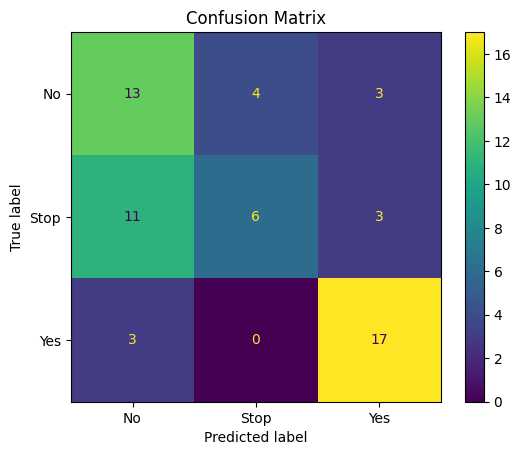

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=[train_dataset.label_map[i] for i in range(num_classes)]).plot()
plt.title("Confusion Matrix")
plt.show()

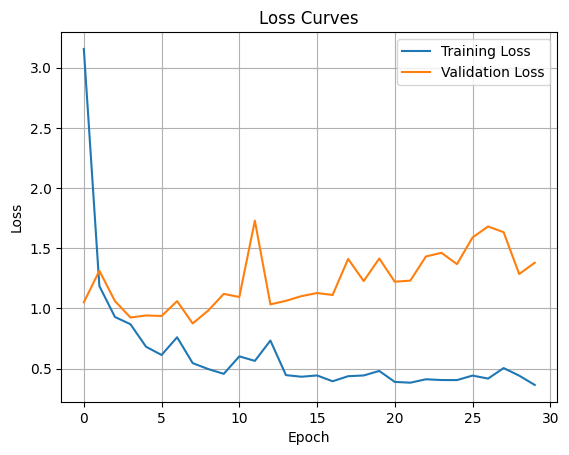

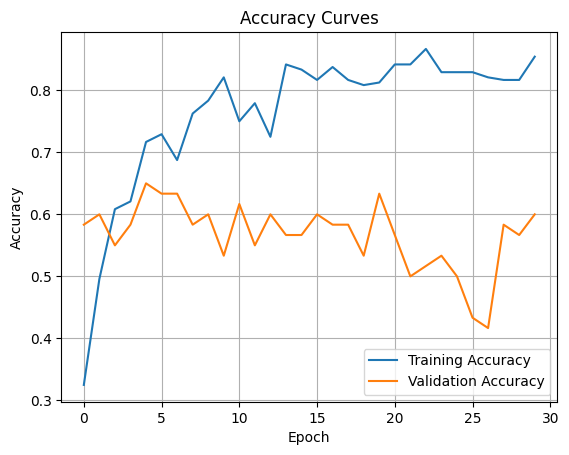

In [26]:
plt.figure()
plt.plot(history['train_loss'], label="Training Loss")
plt.plot(history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history['train_accuracy'], label="Training Accuracy")
plt.plot(history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.grid(True)
plt.show()